In [1]:
import os, csv
import pandas as pd

In [2]:
dir_mcd = os.path.abspath(os.curdir)+os.sep+'marketcap_data'+os.sep+'csv'+os.sep
dir_hd = os.path.abspath(os.curdir)+os.sep+'historic_data'+os.sep+'csv'+os.sep
files_mcd = [dir_mcd+i for i in os.listdir(dir_mcd)]
files_hd = [dir_hd+i for i in os.listdir(dir_hd)]

In [3]:
def get_data(files_path):
    all_data = []
    for path_in in files_path:
        with open(path_in, 'r') as in_file:
            ticker = path_in.split('\\csv\\')[1].split('.csv')[0]
            for i, line in enumerate(in_file):
                if i == 0: continue
                line = list(csv.reader([line]))[0]
                line.append(ticker)
                all_data.append(line)
    return all_data

In [4]:
def first_days_top(files_path):
    all_data_mcd = get_data(files_path)
    df = pd.DataFrame(all_data_mcd, columns = ['Date', 'Marketcap', 'Ticker']).drop_duplicates()
    df['Marketcap'] = pd.to_numeric(df['Marketcap'])
    df.index = df['Date']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    first_days_list = []
    first_day = 0
    for i in df.index.unique():
        if first_day == 0:
            first_days_list.append(i)
            first_day = i
        else:
            if i.month == first_day.month:
                pass
            else:
                first_days_list.append(i)
                first_day = i
                
    dict_top = {}
    for i in first_days_list:
        df_top = df[df.index == i]
        df_top = df_top.sort_values(['Marketcap'])
        dict_top[i] = list(df_top.tail(10).Ticker.values)

    for i in list(dict_top):
        if len(dict_top[i]) < 10:
            dict_top.pop(i)
        
    return dict_top

In [5]:
dict_top = first_days_top(files_mcd)
# {Timestamp('2000-02-01 00:00:00'): ['KLS.TO','VRTK', 'TPRP','PTN', 'GEO','AIR','MT','KEY','RTOKY','AKAM'],...}

df_top = pd.DataFrame(dict_top).T
df_top.index = pd.to_datetime(df_top.index)
df_top = df_top.sort_index()

In [6]:
df_top # top 10 tickers by market cap

,0,1,2,3,4,5,6,7,8,9
1999-12-01,CFIN,KLS.TO,VRTK,PTN,TPRP,GEO,AIR,MT,KEY,RTOKY
2000-02-01,KLS.TO,VRTK,TPRP,PTN,GEO,AIR,MT,KEY,RTOKY,AKAM
2000-03-01,VITFF,KLS.TO,TPRP,PTN,GEO,AIR,MT,KEY,RTOKY,AKAM
2000-04-03,KMFI,VRTK,KLS.TO,TPRP,PTN,GEO,AIR,MT,KEY,AKAM
2000-05-01,KLS.TO,TPRP,PTN,ROFO,GEO,AIR,MT,KEY,AKAM,RTOKY
...,...,...,...,...,...,...,...,...,...,...
2020-03-02,FJTSF,BAC,UNH,T,RHHBY,BABA,GOOGL,GOOG,AMZN,AAPL
2020-04-01,UL,LLY,ABT,BAC,T,UNH,BABA,GOOGL,GOOG,AAPL
2020-05-01,UL,LLY,ABT,BAC,T,UNH,BABA,GOOGL,GOOG,AAPL
2020-06-01,FJTSF,BAC,T,UNH,RHHBY,BABA,GOOG,GOOGL,AMZN,AAPL


In [7]:
all_data_hd = get_data(files_hd) #[['04-01-2000', '1.0727678537368774', '0003.HK'],...]

df_hd = pd.DataFrame(all_data_hd, columns = ['Date', 'Adj_price', 'Ticker']).drop_duplicates().dropna()
df_hd['Adj_price'] = pd.to_numeric(df_hd['Adj_price'])
df_hd.index = df_hd['Date']
df_hd.index = pd.to_datetime(df_hd.index)
df_hd = df_hd.sort_index()

In [8]:
df_hd.head(3) # All historical data

,Date,Adj_price,Ticker
Date,,,
1970-01-01,01-01-1970,0.000000,XJOMOQ-A
1970-01-04,01-04-1970,0.000588,MO
1970-01-04,01-04-1970,NaN,MLT.AX


In [9]:
def take_price(date):
    price = df_hd.loc[(df_hd.index == date) & (df_hd['Ticker'] == t)]
    if price.empty:
        while price.empty:
            price = df_hd.loc[(df_hd.index == date - pd.Timedelta(1, unit='d')) & (df_hd['Ticker'] == t)]
            date = date - pd.Timedelta(1, unit='d')
    return price.Adj_price.values[0]

In [ ]:
final_list = []
prev_m = 0
for d in dict_top:
    if d > pd.Timestamp('2017-01-01 00:00:00'): # take last 3 years
        for t in dict_top[d]:
            if prev_m != 0:
                price = df_hd.loc[(df_hd.index == d) & (df_hd['Ticker'] == t)]
                if not price.empty:
                    price = price.Adj_price.values[0]
                    prev_price = take_price(prev_m)
                    next_price = take_price(d + pd.offsets.DateOffset(months=1))
                    final_list.append([str(d.date()), t, prev_price, price, next_price])
    prev_m = d

In [11]:
final_df = pd.DataFrame(final_list, columns = ['Date', 'Ticker', 'Prev_Price', 'Price', 'Next_Price'])
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df['prev_perf'] = (final_df['Price'] - final_df['Prev_Price']) / final_df['Prev_Price']
final_df['perf'] = (final_df['Next_Price'] - final_df['Price']) / final_df['Price']
final_df['weight'] = abs(final_df['prev_perf'])
final_df['dir'] = [1 if i >= 0 else -1 for i in final_df['prev_perf']]
final_df['total_weigth'] = 0

In [12]:
exist_tickers = final_df.groupby(['Date']).sum()
for d in exist_tickers.iterrows():
    for i, row in enumerate(final_df.iterrows()):
        if final_df['Date'][i] == d[0]:
            final_df.loc[i, 'total_weigth'] = d[1][5]

In [13]:
final_df['percent_weight'] = final_df['weight'] / final_df['total_weigth']
final_df['profit'] = final_df['percent_weight'] * final_df['perf'] * final_df['dir']
final_df.head()

,Date,Ticker,Prev_Price,Price,Next_Price,prev_perf,perf,weight,dir,total_weigth,percent_weight,profit
0,2017-01-03,ABBV,43.922665,52.794765,53.147682,0.201994,0.006685,0.201994,1,1.981704,0.101929,0.000681
1,2017-01-03,BPAQF,3.367794,4.556115,4.572301,0.352848,0.003553,0.352848,1,1.981704,0.178053,0.000633
2,2017-01-03,RHHBY,28.211403,26.812368,28.453585,-0.049591,0.061211,0.049591,-1,1.981704,0.025024,-0.001532
3,2017-01-03,BAC,14.059166,23.855652,23.603056,0.696804,-0.010589,0.696804,1,1.981704,0.351619,-0.003723
4,2017-01-03,AMZN,617.890015,853.080017,848.909973,0.380634,-0.004888,0.380634,1,1.981704,0.192074,-0.000939


In [17]:
exist_tickers = final_df.groupby(['Date']).sum()

In [18]:
index = 1
index_list = []
for d in exist_tickers.iterrows():
    index += d[1][9]
    index_list.append([str(d[0].date()), index])

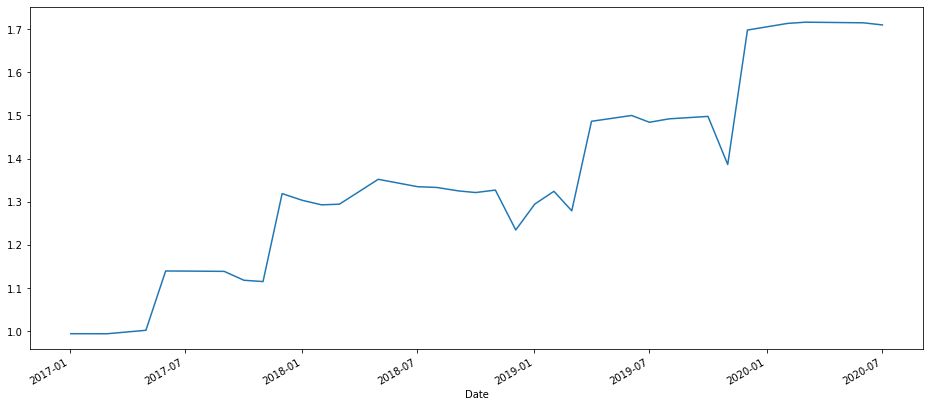

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(index_list, columns = ['Date', 'Index'])
df.index = df['Date']
df.index = pd.to_datetime(df.index)

df['Index'].plot(figsize=(16,7))